In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline
!pip install graphviz
!pip install dmba

In [232]:
from dmba import classificationSummary

In [233]:
df = pd.read_excel('ebaydataset.xlsx',sheet_name='eBay auctions')
df.head(20)

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
5,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
6,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
7,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
8,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
9,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


Target Variable - Competitive

In [234]:
df.shape

(1972, 8)

In [235]:
df.info()

# As we can see that there are no null values in the dataset. So we don't need to handle missing values. But I will still double check.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Category      1972 non-null   object 
 1   Currency      1972 non-null   object 
 2   sellerRating  1972 non-null   int64  
 3   Duration      1972 non-null   int64  
 4   endDay        1972 non-null   object 
 5   ClosePrice    1972 non-null   float64
 6   OpenPrice     1972 non-null   float64
 7   Competitive?  1972 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 123.4+ KB


In [236]:
missing_values = df.isnull().sum()
print("Number of missing values: \n", missing_values)

Number of missing values: 
 Category        0
Currency        0
sellerRating    0
Duration        0
endDay          0
ClosePrice      0
OpenPrice       0
Competitive?    0
dtype: int64


In [237]:
df.describe().round(3)

# Seller Rating mean is approximately 3560 and median is 1853. So the data is right skewed.
# Auction open price is typically around 4.5, but some auctions have opening prices as high as 1000. Need to be investigated further.

,sellerRating,Duration,ClosePrice,OpenPrice,Competitive?
count,1972.000,1972.000,1972.000,1972.000,1972.000
mean,3560.238,6.486,36.449,12.926,0.541
std,5973.011,2.053,89.494,38.856,0.498
min,0.000,1.000,0.010,0.010,0.000
25%,595.000,5.000,4.908,1.230,0.000
50%,1853.000,7.000,9.995,4.500,1.000
75%,3380.000,7.000,28.000,9.990,1.000
max,37727.000,10.000,999.000,999.000,1.000


In [238]:
df['Competitive?'].value_counts(normalize=True)*100

Competitive?
1    54.056795
0    45.943205
Name: proportion, dtype: float64

In [239]:
df.head(10)

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
5,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
6,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
7,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
8,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
9,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [240]:
# Task 1: Renaming the columns to remove spaces, special characters and bringing uniformity.

df.columns = df.columns.str.replace(" ", "_").str.replace("?", "").str.lower()

df.rename(
    columns={
        "category": "category",
        "duration": "duration",
        "currency": "currency",
        "sellerrating": "seller_rating",
        "openprice": "open_price",
        "closeprice": "close_price",
        "endday": "end_day",
        "competitive": "competitive",
    },
    inplace=True)

In [241]:
# Task 2: Checking for duplicates
df.duplicated().sum()

print("Number of duplicate rows: ", df.duplicated().sum())

Number of duplicate rows:  346


In [242]:
duplicates = df[df.duplicated(keep=False)]
duplicates

,category,currency,seller_rating,duration,end_day,close_price,open_price,competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
...,...,...,...,...,...,...,...,...
1926,Pottery/Glass,US,993,7,Sat,99.99,99.99,0
1927,Pottery/Glass,US,993,7,Sat,99.99,99.99,0
1928,Pottery/Glass,US,993,7,Sat,99.99,99.99,0
1941,Automotive,US,1364,7,Tue,128.00,128.00,0


In [243]:
# I will only keep the first occurrence of the duplicate rows and drop the rest.
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

# sanity check
print("Number of rows after removing duplicates: ", df.shape)
print("Number of duplicate rows after removing duplicates: ", df.duplicated().sum())

Number of rows after removing duplicates:  (1626, 8)
Number of duplicate rows after removing duplicates:  0


In [244]:
df.head(10)

,category,currency,seller_rating,duration,end_day,close_price,open_price,competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Automotive,US,3115,7,Tue,0.01,0.01,0
2,Automotive,US,3115,7,Tue,0.01,0.01,1
3,Music/Movie/Game,US,37727,7,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.06,0.01,1
5,Music/Movie/Game,US,3249,5,Mon,0.10,0.01,1
6,SportingGoods,US,34343,1,Fri,0.11,0.01,1
7,Music/Movie/Game,US,3249,5,Mon,0.11,0.01,1
8,Music/Movie/Game,US,3249,5,Mon,0.17,0.01,1
9,Music/Movie/Game,US,3249,5,Mon,0.21,0.01,1


In [245]:
# Task 3: Checking dataypes
df.dtypes

category          object
currency          object
seller_rating      int64
duration           int64
end_day           object
close_price      float64
open_price       float64
competitive        int64
dtype: object

In [246]:
# Task 4: Converting the datatypes to appropriate types
categorical_cols = ['category','currency', 'end_day']
for col in categorical_cols:
    df[col] = df[col].astype('category')

#sanity check
df.dtypes


category         category
currency         category
seller_rating       int64
duration            int64
end_day          category
close_price       float64
open_price        float64
competitive         int64
dtype: object

Analysis

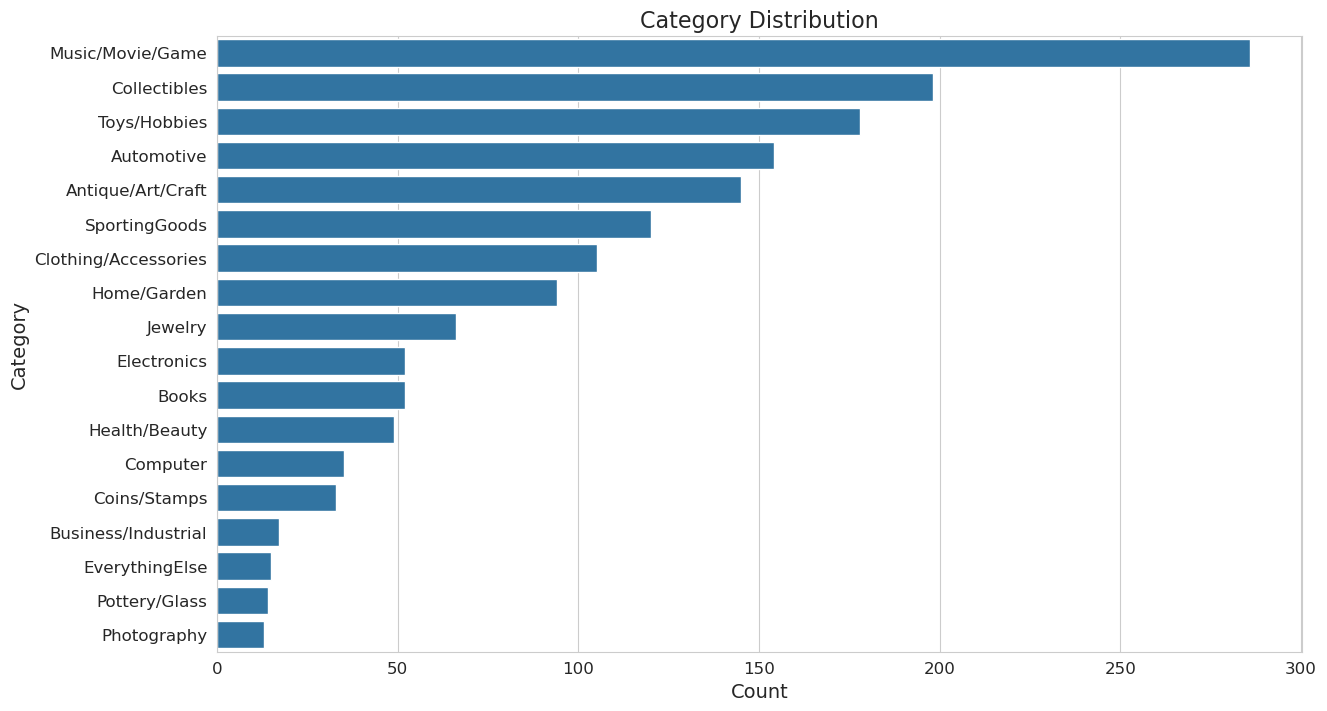

In [247]:
plt.figure(figsize=(14,8)) 
sns.set_style('whitegrid')  


order = df['category'].value_counts().index

sns.countplot(
    data=df,
    y='category',
    order=order 
)

plt.title('Category Distribution', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()

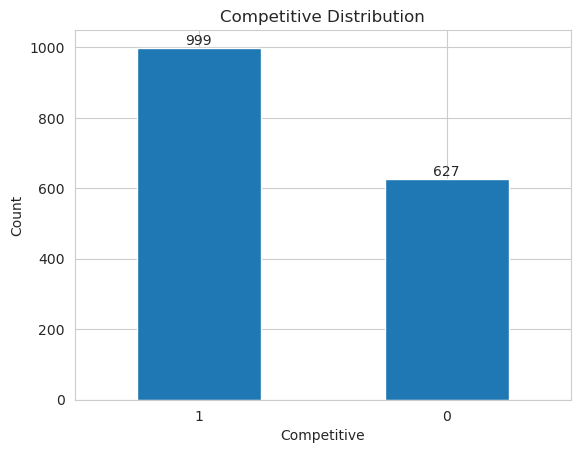

In [248]:
counts = df['competitive'].value_counts()
ax = counts.plot(kind='bar', rot=0)
plt.title('Competitive Distribution')
plt.xlabel('Competitive')
plt.ylabel('Count')


for i, v in enumerate(counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.show()

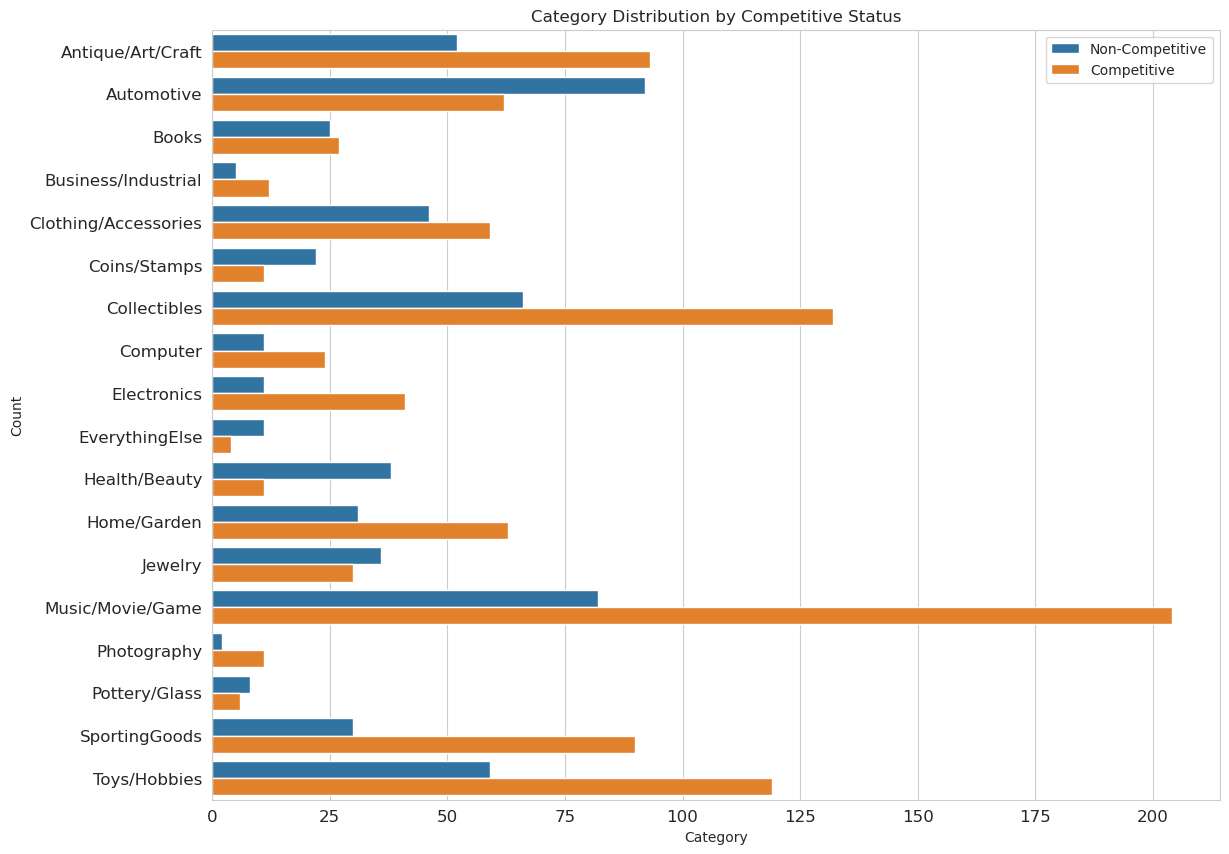

In [249]:
# Which categories are more competitive and how common different categories are.

plt.figure(figsize=(13,10))
sns.countplot(data=df, y='category', hue='competitive')
plt.title('Category Distribution by Competitive Status')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(loc='upper right', labels=['Non-Competitive', 'Competitive'])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

# Top 3 competitive auctions are in categories: Music/Movie/Games, Collectibles and Toys/Hobbies.
# Top 3 non-competitive auctions are in categories: Automotive, Music/Movie/Games and Collectibles.

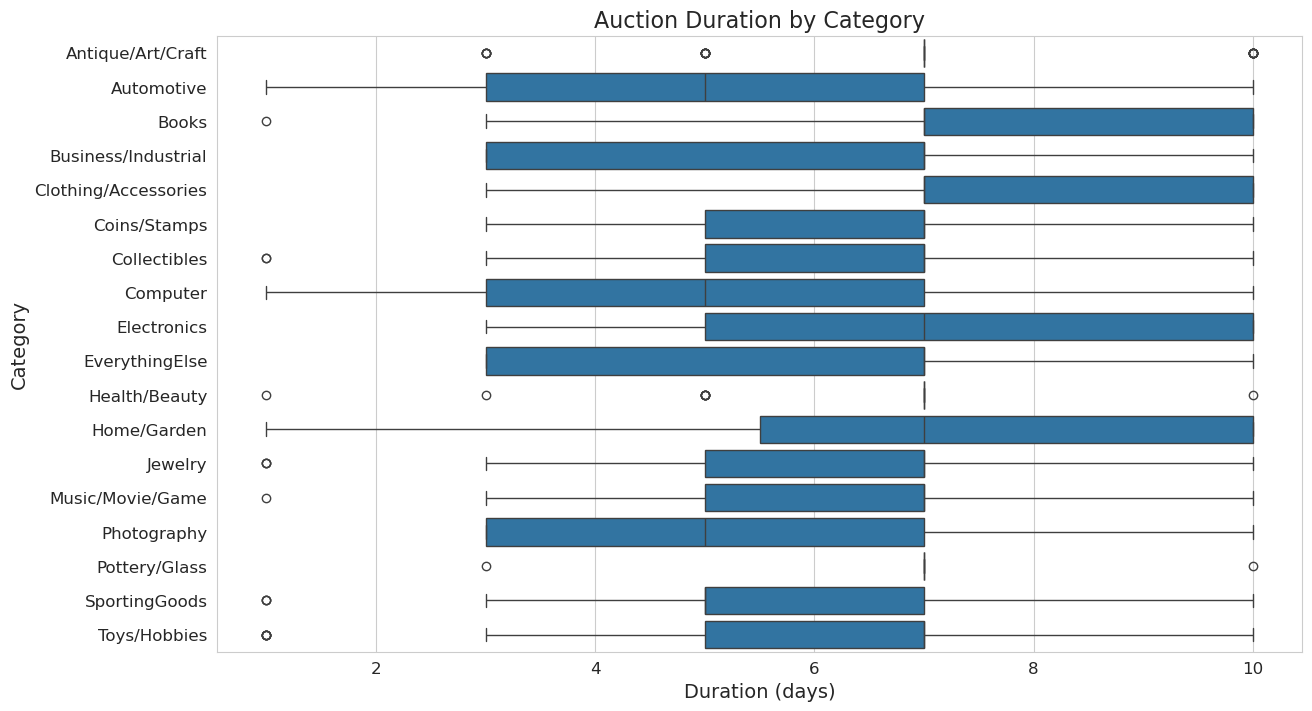

In [250]:
# Which categories tend to have longer auction durations?

plt.figure(figsize=(14,8))  
sns.set_style('whitegrid')


sns.boxplot(
    data=df,
    x='duration',
    y='category'
)

plt.title('Auction Duration by Category', fontsize=16)
plt.xlabel('Duration (days)', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


# Most Auctions run for 5-7 days.

In [251]:
# Cross Tab Analysis between 'category' and 'competitive'
category_cross_tab = pd.crosstab(df['category'], df['competitive'], margins=False, normalize='index').round(3)
category_cross_tab

competitive,0,1
category,,
Antique/Art/Craft,0.359,0.641
Automotive,0.597,0.403
Books,0.481,0.519
Business/Industrial,0.294,0.706
Clothing/Accessories,0.438,0.562
Coins/Stamps,0.667,0.333
Collectibles,0.333,0.667
Computer,0.314,0.686
Electronics,0.212,0.788


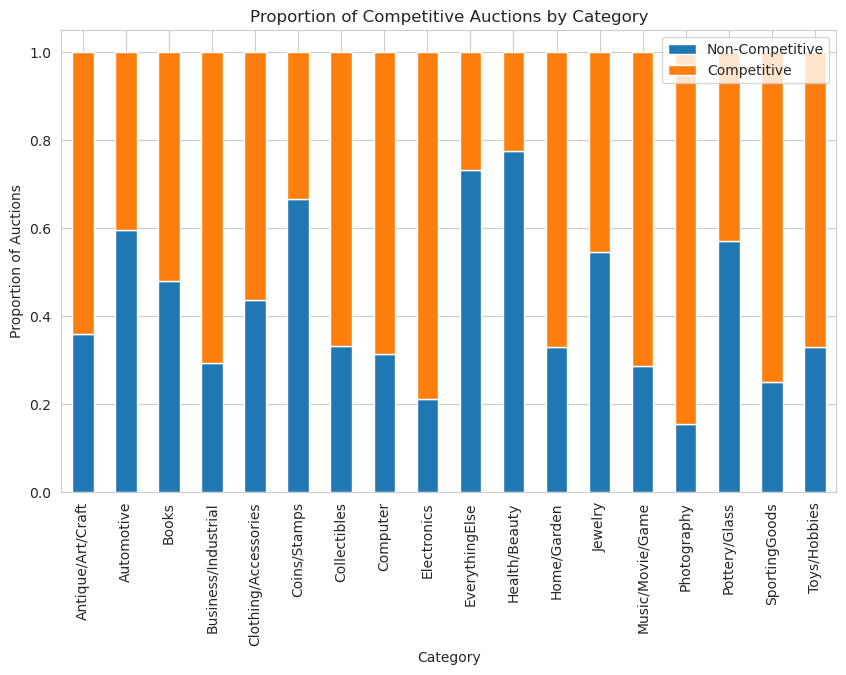

In [252]:
category_cross_tab.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Proportion of Competitive Auctions by Category')
plt.xlabel('Category')
plt.ylabel('Proportion of Auctions')
plt.legend(loc='upper right', labels=['Non-Competitive', 'Competitive'])
plt.show()

In [253]:
df['currency'].value_counts()

currency
US     1025
EUR     470
GBP     131
Name: count, dtype: int64

Cross Tabulation between 'currency' and 'competitive':
 competitive      0      1
currency                 
EUR          0.400  0.600
GBP          0.252  0.748
US           0.396  0.604 



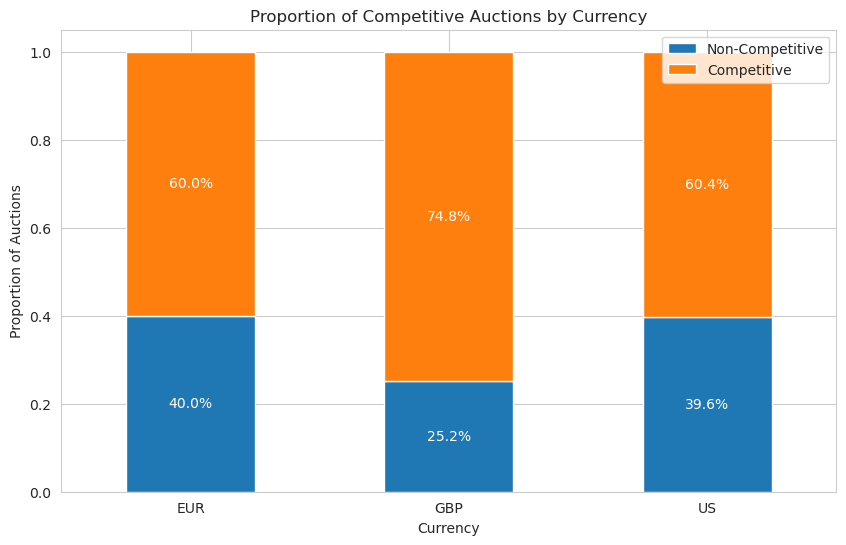

Cross Tabulation between 'end_day' and 'competitive':
 competitive      0      1
end_day                  
Mon          0.273  0.727
Tue          0.429  0.571
Wed          0.477  0.523
Thu          0.335  0.665
Fri          0.440  0.560
Sat          0.447  0.553
Sun          0.449  0.551 



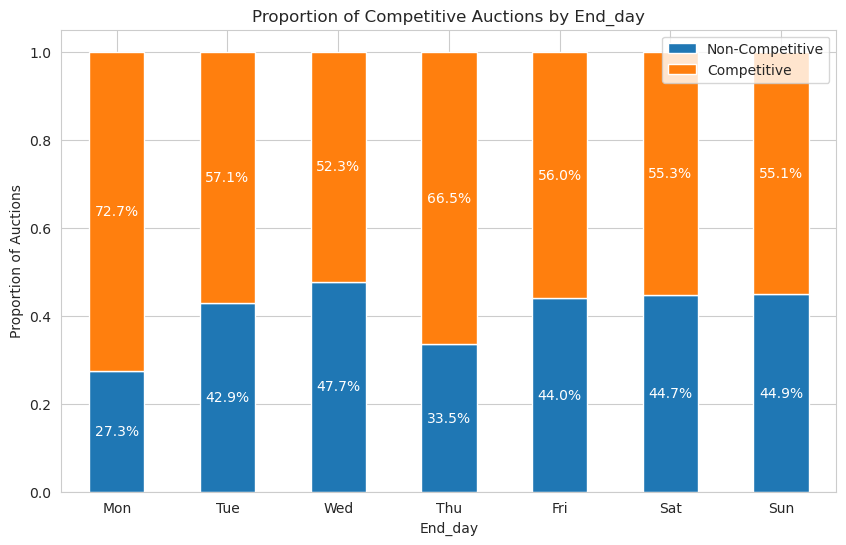

Cross Tabulation between 'duration' and 'competitive':
 competitive      0      1
duration                 
1            0.478  0.522
3            0.495  0.505
5            0.278  0.722
7            0.410  0.590
10           0.387  0.613 



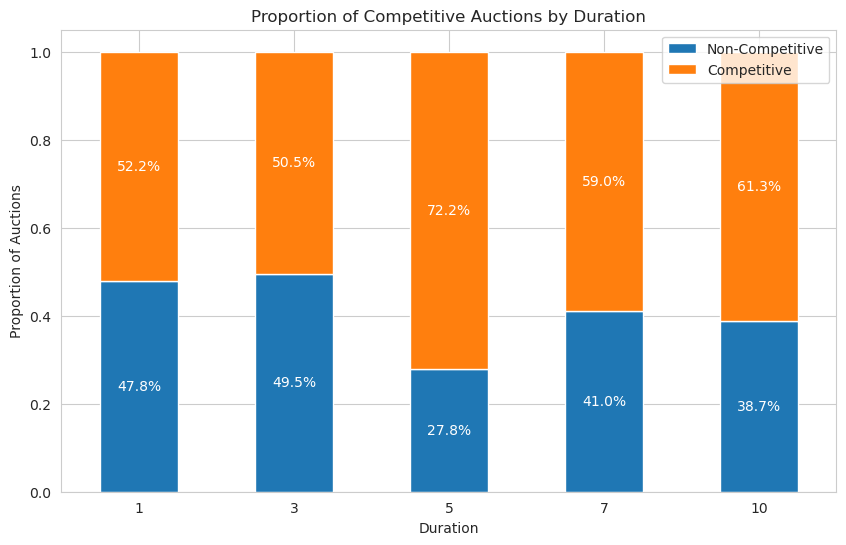

In [254]:
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['end_day'] = pd.Categorical(df['end_day'], categories=day_order, ordered=True)

cat_cols = ['currency', 'end_day', 'duration']
target_col = 'competitive'

for col in cat_cols:
    cross_tab = pd.crosstab(df[col], df[target_col], margins=False, normalize='index').round(3)
    print(f"Cross Tabulation between '{col}' and '{target_col}':\n", cross_tab, "\n")

    ax = cross_tab.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Proportion of Competitive Auctions by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Proportion of Auctions')
    plt.legend(loc='upper right', labels=['Non-Competitive', 'Competitive'])
    plt.xticks(rotation=0)

    # Add proportion percentages on top of each segment
    for i, row in enumerate(cross_tab.values):
        bottom = 0
        for j, val in enumerate(row):
            if val > 0:
                ax.text(i, bottom + val/2, f'{val*100:.1f}%', ha='center', va='center', color='white', fontsize=10)
            bottom += val

    plt.show()



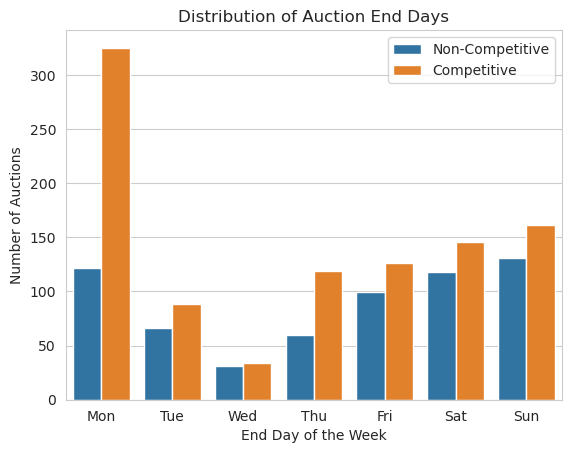

In [255]:
sns.countplot(data=df, x='end_day', hue='competitive')
plt.title('Distribution of Auction End Days')
plt.xlabel('End Day of the Week')
plt.ylabel('Number of Auctions')
plt.legend(loc='upper right', labels=['Non-Competitive', 'Competitive'])
plt.show()

# Monday is prime time. This is when the market is most active with the highest traffic and engagement.
# Wednesday represents a "dead zone" with lowest competitive auctions.

array([[<Axes: title={'center': 'seller_rating'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'open_price'}>,
        <Axes: title={'center': 'close_price'}>]], dtype=object)

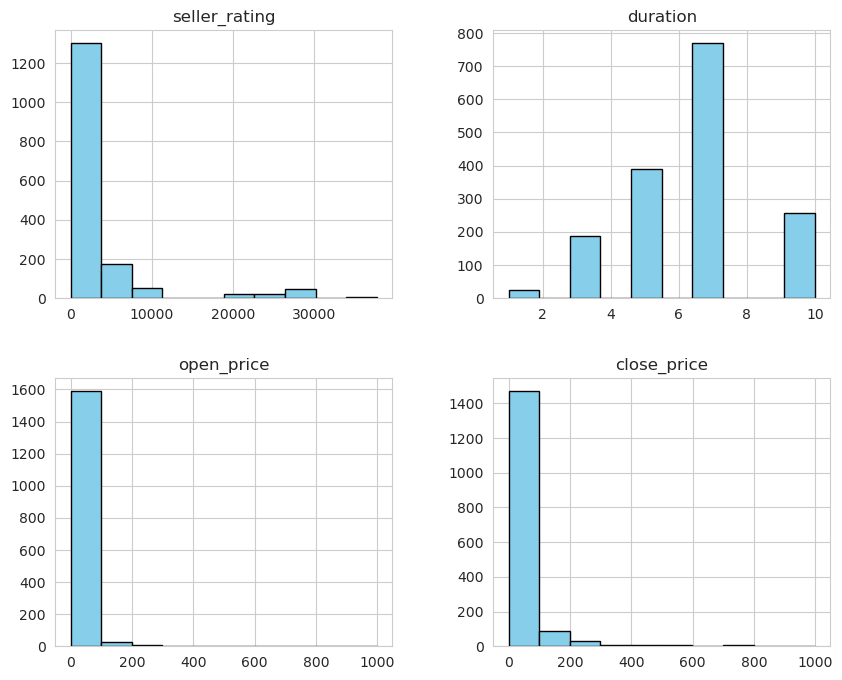

In [256]:
numeric_cols = ['seller_rating', 'duration', 'open_price', 'close_price']

df[numeric_cols].hist(figsize=(10,8), color='skyblue', edgecolor='black')

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

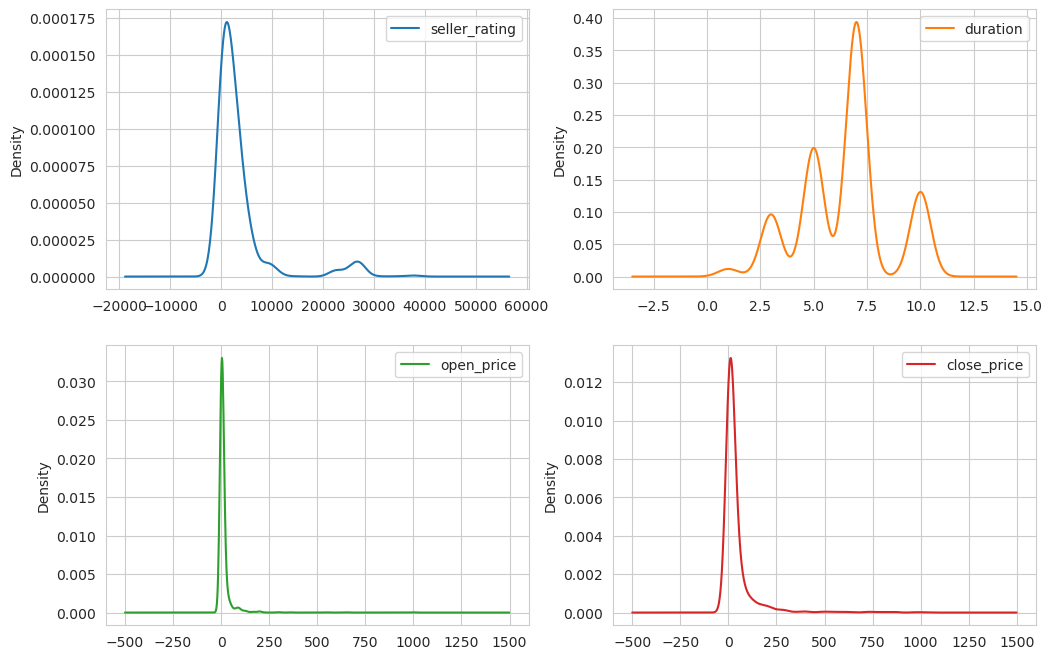

In [257]:
df[numeric_cols].plot(figsize=(12,8), kind='density', subplots=True, layout=(2,2), sharex=False)

# Most auctions cluster around 7 days, second highest is 5 days. Multimodal distribution.

In [258]:
df.head()

,category,currency,seller_rating,duration,end_day,close_price,open_price,competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Automotive,US,3115,7,Tue,0.01,0.01,0
2,Automotive,US,3115,7,Tue,0.01,0.01,1
3,Music/Movie/Game,US,37727,7,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.06,0.01,1


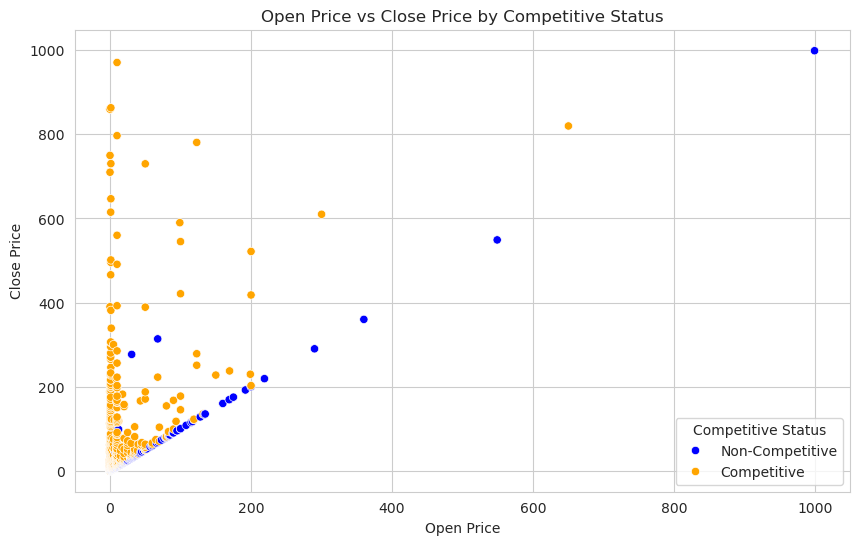

In [259]:
df['competitive_label'] = df['competitive'].map({0: 'Non-Competitive', 1: 'Competitive'})

plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df,
    x='open_price',
    y='close_price',
    hue='competitive_label',
    palette={'Non-Competitive':'blue', 'Competitive':'orange'}
)

plt.title('Open Price vs Close Price by Competitive Status')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.legend(title='Competitive Status')
plt.show()

# When open price is high, tyically above 180, the auction is non-competitive. Competitive auctions have lower open prices.
# Comptetitive auctions are typically below 200 in open price.
# Non-competitive items have more pricing flexibility and can command premium prices.
# Close prices seem to be very similiar to open prices for both competitive and non-competitive auctions.

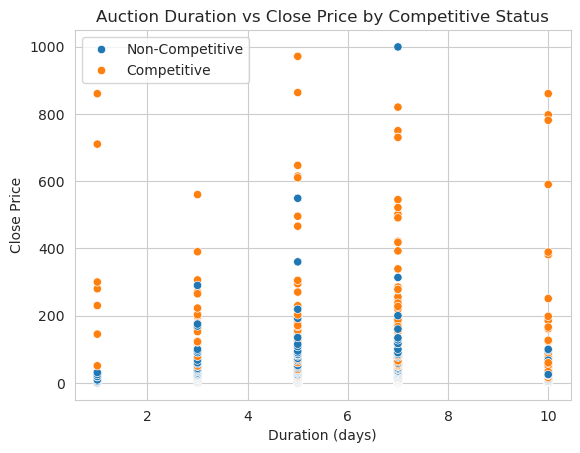

In [260]:
# Auction Duration v/s Closing Price - Checking if longer duration leads to higher closing prices or attract more bids.

sns.scatterplot(data=df, x='duration', y='close_price', hue='competitive_label')
plt.title('Auction Duration vs Close Price by Competitive Status')
plt.xlabel('Duration (days)')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# There is no clear correlation between auction duration and closing price.
# Auction duration doesn't appear to be a major factor in determining final prices.

In [261]:
df = df.drop(columns=['competitive_label'])

In [262]:
df.head()

,category,currency,seller_rating,duration,end_day,close_price,open_price,competitive
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Automotive,US,3115,7,Tue,0.01,0.01,0
2,Automotive,US,3115,7,Tue,0.01,0.01,1
3,Music/Movie/Game,US,37727,7,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.06,0.01,1


array([[<Axes: xlabel='seller_rating', ylabel='seller_rating'>,
        <Axes: xlabel='duration', ylabel='seller_rating'>,
        <Axes: xlabel='close_price', ylabel='seller_rating'>,
        <Axes: xlabel='open_price', ylabel='seller_rating'>,
        <Axes: xlabel='competitive', ylabel='seller_rating'>],
       [<Axes: xlabel='seller_rating', ylabel='duration'>,
        <Axes: xlabel='duration', ylabel='duration'>,
        <Axes: xlabel='close_price', ylabel='duration'>,
        <Axes: xlabel='open_price', ylabel='duration'>,
        <Axes: xlabel='competitive', ylabel='duration'>],
       [<Axes: xlabel='seller_rating', ylabel='close_price'>,
        <Axes: xlabel='duration', ylabel='close_price'>,
        <Axes: xlabel='close_price', ylabel='close_price'>,
        <Axes: xlabel='open_price', ylabel='close_price'>,
        <Axes: xlabel='competitive', ylabel='close_price'>],
       [<Axes: xlabel='seller_rating', ylabel='open_price'>,
        <Axes: xlabel='duration', ylabel='open_

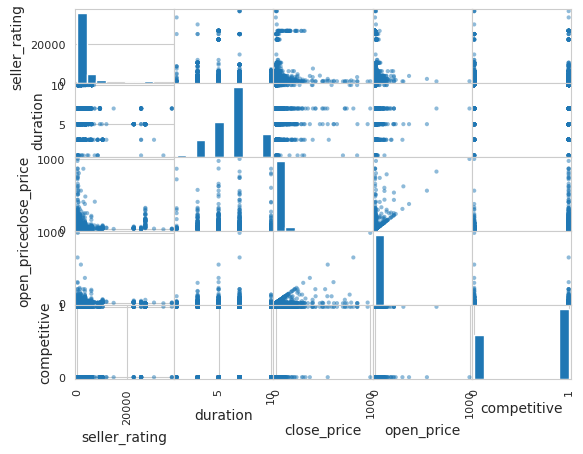

In [263]:
from pandas.plotting import scatter_matrix
scatter_matrix(df)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1626 entries, 0 to 1625
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   category       1626 non-null   category
 1   currency       1626 non-null   category
 2   seller_rating  1626 non-null   int64   
 3   duration       1626 non-null   int64   
 4   end_day        1626 non-null   category
 5   close_price    1626 non-null   float64 
 6   open_price     1626 non-null   float64 
 7   competitive    1626 non-null   int64   
dtypes: category(3), float64(2), int64(3)
memory usage: 69.6 KB


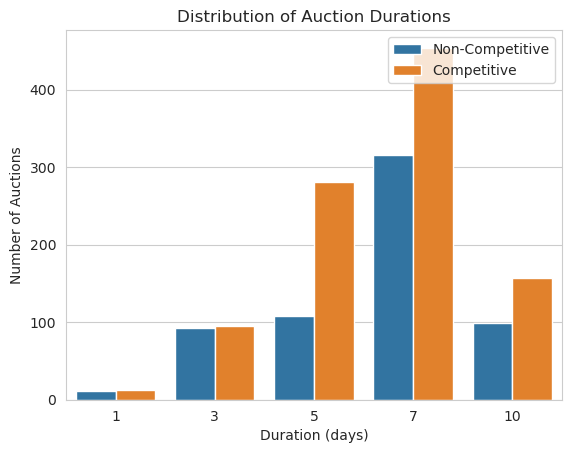

In [265]:
sns.countplot(data=df, x='duration', hue='competitive')
plt.title('Distribution of Auction Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Auctions')
plt.legend(loc='upper right', labels=['Non-Competitive', 'Competitive'])
plt.show()

# This plot confirms results from boxplot above. Most auctions run for 7 days, followed by 5 days.
# Majority of auctions, both competitive and non-competitive, run for 7 days. 5-day auctions are second most common.

In [266]:
df['category'].value_counts()

category
Music/Movie/Game        286
Collectibles            198
Toys/Hobbies            178
Automotive              154
Antique/Art/Craft       145
SportingGoods           120
Clothing/Accessories    105
Home/Garden              94
Jewelry                  66
Electronics              52
Books                    52
Health/Beauty            49
Computer                 35
Coins/Stamps             33
Business/Industrial      17
EverythingElse           15
Pottery/Glass            14
Photography              13
Name: count, dtype: int64

In [267]:
df['currency'].value_counts()

currency
US     1025
EUR     470
GBP     131
Name: count, dtype: int64

In [268]:
df['end_day'].value_counts()

end_day
Mon    447
Sun    292
Sat    264
Fri    225
Thu    179
Tue    154
Wed     65
Name: count, dtype: int64

In [269]:
# For k-NN and tree-based models, this restriction for k-1 variables is unnecessary, in fact, using all k dummy variables can work better. This way, each category gets its own column, and no single category is treated as the “baseline”. Since in assignment we are only using KNN and decision trees, so I will not use baseline encoding and will kep drop_first=False.

df['currency'] = df['currency'].str.lower().str.strip()
df = pd.get_dummies(df, columns=['currency'], drop_first=False)

In [270]:
df['end_day'] = df['end_day'].str.lower().str.strip()
df = pd.get_dummies(df, columns=['end_day'], drop_first=False)

In [271]:
df['category'] = df['category'].str.lower().str.strip()
df = pd.get_dummies(df, columns=['category'], drop_first=False)

In [272]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [273]:
df.head()

,seller_rating,duration,close_price,open_price,competitive,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
0,3249,5,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3115,7,0.01,0.01,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3115,7,0.01,0.01,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37727,7,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3249,5,0.06,0.01,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


The thing to note here is that now I have 33 columns and 1626 rows. For KNN as the number of predictor increases, the curse of dimensionality becomes a problem. For now I am moving forward with this but in case if results are too bad, then I will try another encoding with a threshold value and put the columns which are below that threshold into other column. But it should not be a problem here becasue:

If we calculate ratio of rows to features = 1626 ÷ 33, approximately 49 rows per feature. Problems usually start when we have hundreds of features with only a few hundred rows. Where p>n. 

In [274]:
df.columns

Index(['seller_rating', 'duration', 'close_price', 'open_price', 'competitive',
       'currency_eur', 'currency_gbp', 'currency_us', 'end_day_fri',
       'end_day_mon', 'end_day_sat', 'end_day_sun', 'end_day_thu',
       'end_day_tue', 'end_day_wed', 'category_antique/art/craft',
       'category_automotive', 'category_books', 'category_business/industrial',
       'category_clothing/accessories', 'category_coins/stamps',
       'category_collectibles', 'category_computer', 'category_electronics',
       'category_everythingelse', 'category_health/beauty',
       'category_home/garden', 'category_jewelry', 'category_music/movie/game',
       'category_photography', 'category_pottery/glass',
       'category_sportinggoods', 'category_toys/hobbies'],
      dtype='object')

In [275]:
df.head()

,seller_rating,duration,close_price,open_price,competitive,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
0,3249,5,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3115,7,0.01,0.01,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3115,7,0.01,0.01,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37727,7,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3249,5,0.06,0.01,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [276]:
correlation_matrix = df.corr(numeric_only=True)
correlation_matrix

,seller_rating,duration,close_price,open_price,competitive,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
seller_rating,1.000000,-0.159474,0.002596,-0.047795,-0.022436,-0.209345,-0.121998,0.265391,-0.019473,0.291415,-0.041088,-0.078403,-0.136432,-0.077623,-0.064855,-0.043776,-0.044905,-0.065706,-0.015592,-0.105605,0.002354,-0.040796,-0.059229,-0.058049,-0.031528,-0.055579,-0.070405,0.086882,-0.058802,-0.047086,-0.025272,0.423249,0.085213
duration,-0.159474,1.000000,-0.086776,-0.077123,0.005977,0.473385,0.054247,-0.475160,-0.112134,-0.088113,-0.139403,-0.009425,0.077586,0.191906,0.268547,0.071035,-0.200411,0.081043,-0.021813,0.104801,0.019208,0.047011,-0.069744,0.031204,-0.026592,0.013887,0.080195,-0.022913,-0.044298,-0.045309,0.021353,-0.025245,-0.004190
close_price,0.002596,-0.086776,1.000000,0.470799,0.158315,-0.037475,-0.066336,0.072597,0.019618,0.022083,0.034635,0.022426,-0.072281,-0.043180,-0.014020,-0.087312,0.196713,-0.022336,0.000584,-0.012770,-0.011168,0.004298,0.067443,0.096043,-0.019530,-0.058282,-0.035552,-0.033392,-0.146865,0.127143,0.016455,0.135363,-0.057091
open_price,-0.047795,-0.077123,0.470799,1.000000,-0.112925,-0.120641,-0.056069,0.144912,0.052179,-0.064196,0.054637,0.053052,-0.068038,-0.006093,-0.034652,-0.053142,0.340255,-0.023968,0.002663,-0.038456,0.047901,-0.044162,-0.018949,0.019049,-0.010864,-0.024123,-0.045527,-0.021150,-0.092173,0.009253,0.044356,-0.037177,-0.013292
competitive,-0.022436,0.005977,0.158315,-0.112925,1.000000,-0.018853,0.081312,-0.028142,-0.044782,0.142541,-0.055502,-0.060577,0.036429,-0.028550,-0.038282,0.017349,-0.140742,-0.035535,0.019321,-0.028332,-0.083109,0.039992,0.021734,0.065002,-0.068935,-0.141202,0.028408,-0.067548,0.093867,0.042747,-0.035578,0.078645,0.039004
currency_eur,-0.209345,0.473385,-0.037475,-0.120641,-0.018853,1.000000,-0.188749,-0.832712,0.027358,-0.110020,-0.107824,-0.050908,-0.016213,0.141246,0.320026,-0.109070,-0.118211,0.038316,0.014486,0.334781,-0.043668,-0.009262,0.026952,0.123133,-0.061527,-0.056847,0.109453,0.068215,-0.077214,-0.026776,-0.059423,-0.024318,-0.067138
currency_gbp,-0.121998,0.054247,-0.066336,-0.056069,0.081312,-0.188749,1.000000,-0.386580,-0.118628,-0.182269,-0.130325,-0.138493,0.841633,-0.095746,-0.060405,-0.084695,-0.072595,0.036096,-0.008211,-0.041000,0.101620,-0.061857,-0.028335,-0.053804,0.018708,-0.052179,0.130000,-0.003634,0.160000,-0.001202,0.045787,-0.040344,-0.024177
currency_us,0.265391,-0.475160,0.072597,0.144912,-0.028142,-0.832712,-0.386580,1.000000,0.041194,0.206094,0.174745,0.125898,-0.459322,-0.078664,-0.266489,0.150186,0.151949,-0.056336,-0.008975,-0.291287,-0.016287,0.043575,-0.009335,-0.085301,0.047234,0.082808,-0.176091,-0.062014,-0.017700,0.025824,0.029989,0.045586,0.076684
end_day_fri,-0.019473,-0.112134,0.019618,0.052179,-0.044782,0.027358,-0.118628,0.041194,1.000000,-0.246757,-0.176435,-0.187493,-0.140950,-0.129622,-0.081776,0.080841,0.101520,-0.032349,-0.006171,-0.040072,-0.007155,0.019615,-0.010348,-0.012103,0.054481,0.054379,0.007575,0.025878,-0.072865,0.004022,-0.018069,-0.024560,-0.077758
end_day_mon,0.291415,-0.088113,0.022083,-0.064196,0.142541,-0.110020,-0.182269,0.206094,-0.246757,1.000000,-0.271088,-0.288078,-0.216565,-0.199161,-0.125647,0.044169,-0.090961,-0.033627,-0.036206,-0.060897,-0.000703,-0.090276,-0.024885,0.013347,0.027036,-0.003791,-0.058086,0.012956,0.185882,-0.024343,-0.042473,0.147583,-0.079119


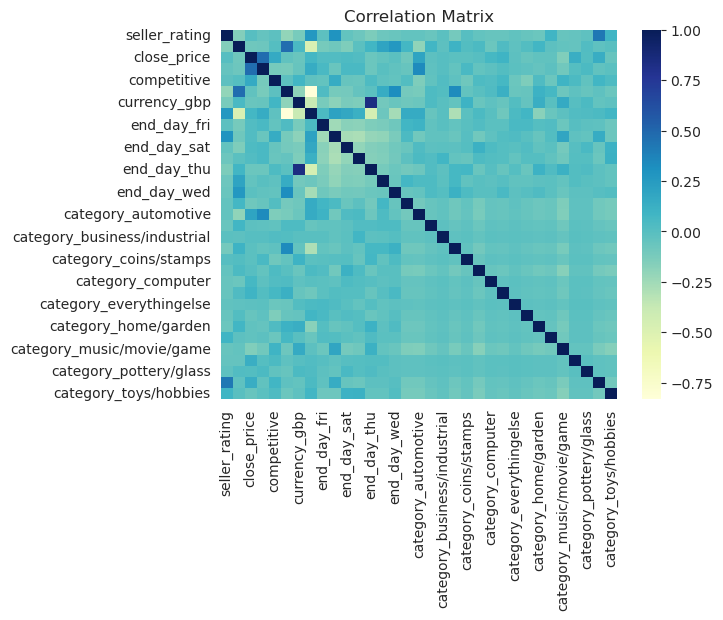

In [277]:
sns.heatmap(correlation_matrix, annot=False, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

In [278]:
pd.set_option('display.max_columns', None)
df.head()

,seller_rating,duration,close_price,open_price,competitive,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
0,3249,5,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3115,7,0.01,0.01,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3115,7,0.01,0.01,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37727,7,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3249,5,0.06,0.01,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Decision Tree Classification

In [279]:
X = df.drop(columns=['competitive'])
y = df['competitive']

In [280]:
X

,seller_rating,duration,close_price,open_price,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
0,3249,5,0.01,0.01,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3115,7,0.01,0.01,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3115,7,0.01,0.01,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37727,7,0.01,0.01,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3249,5,0.06,0.01,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,2992,5,359.95,359.95,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1622,21,5,610.00,300.00,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1623,1400,5,549.00,549.00,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1624,57,7,820.00,650.00,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [281]:
y

0       0
1       0
2       1
3       0
4       1
       ..
1621    0
1622    1
1623    0
1624    1
1625    0
Name: competitive, Length: 1626, dtype: int64

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [283]:
fullClassTree = DecisionTreeClassifier(random_state=1, min_samples_leaf=50)

In [284]:
fullClassTree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [285]:
y_predicted = fullClassTree.predict(X_test)
y_predicted

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,

In [286]:
accuracy_score(y_test, y_predicted)*100

80.95238095238095

In [287]:
classificationSummary(y_train, fullClassTree.predict(X_train))

# It doesn't seem to overfit as training set after looking at the results here of classification summary.

Confusion Matrix (Accuracy 0.8113)

       Prediction
Actual   0   1
     0 302  73
     1 111 489


In [288]:
classificationSummary(y_test, fullClassTree.predict(X_test))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual   0   1
     0 193  59
     1  65 334


In [289]:
print("Max Depth of Tree: ",fullClassTree.tree_.max_depth)
print("Node count of Tree: ",fullClassTree.tree_.node_count)
print("Total leaf nodes: ",fullClassTree.get_n_leaves())

Max Depth of Tree:  6
Node count of Tree:  27
Total leaf nodes:  14


In [290]:
fullClassTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [291]:
# Now I will try to tune the hyperparameters using GridSearchCV to see if I can improve the accuracy.

param_grid = {
    'criterion': ['gini'],   
    'splitter': ['best', 'random'],                
    'max_depth': [5, 10, 15, 20, None],             
    'min_samples_split': [2, 10, 20],      
    'min_samples_leaf': [50],    # Keeping it constant as 50 to avoid overfitting, as directed in assignment         
    'max_features': [None, 'sqrt', 'log2']         
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 50, 'min_samples_split': 2, 'splitter': 'best'}


In [292]:
# Evaluation of the best model from GridSearchCV
fullClassTree_tuned = best_tree

fullClassTree_tuned.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [293]:
y_predicted = fullClassTree_tuned.predict(X_test)
y_predicted

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,

In [294]:
accuracy_score(y_test, y_predicted)*100


80.95238095238095

In [295]:
classificationSummary(y_train, fullClassTree_tuned.predict(X_train))

Confusion Matrix (Accuracy 0.8113)

       Prediction
Actual   0   1
     0 302  73
     1 111 489


In [296]:
print("Max Depth of Tree: ",fullClassTree_tuned.tree_.max_depth)
print("Node count of Tree: ",fullClassTree_tuned.tree_.node_count)
print("Total leaf nodes: ",fullClassTree_tuned.get_n_leaves())

Max Depth of Tree:  5
Node count of Tree:  25
Total leaf nodes:  13


In [297]:
classificationSummary(y_test, fullClassTree_tuned.predict(X_test))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual   0   1
     0 193  59
     1  65 334


In [298]:
fullClassTree_tuned.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

# Is this model practical for predicting the outcome of a new auction?

Tuned model and baseline model had basically same scores, so I am checking generalization on tuned model. Doesn't make a difference because baseline model will also give same results

In [299]:
# We answer this by checking generalization, overfitting, and performance metrics.

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = best_tree.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", round(train_acc, 5))

# Cross-validation accuracy
cv_scores = cross_val_score(best_tree, X_train, y_train, cv=5, scoring='accuracy')
print("Mean CV Score:", cv_scores.mean().round(5))
print("CV Score Std Dev:", cv_scores.std().round(5))

print("Difference between Training and CV Accuracy on tuned model:", round((train_acc - cv_scores.mean()) * 100, 5), "%")

# Small gap between train and CV = model generalizes well = practical.

Training Accuracy: 0.81128
Mean CV Score: 0.76718
CV Score Std Dev: 0.04454
Difference between Training and CV Accuracy on tuned model: 4.41026 %


In [300]:
y_test_pred = best_tree.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", round(test_acc,5))

print("Difference between Training and Test Accuracy:", round((train_acc - test_acc) * 100, 5), "%")

# The decision tree generalizes extremely well to unseen data. With a test accuracy of 80.95% and a negligible difference of 0.18% from training accuracy, the model is practical for predicting the outcome of new auctions.

Test Accuracy: 0.80952
Difference between Training and Test Accuracy: 0.17582 %


# Suppose you had to slightly reduce the number of predictors due to software limitations, or for clarity of presentation, which would be (a) good variable(s) to choose?

In [301]:
importances = best_tree.feature_importances_

feature_importance_df = pd.DataFrame({"feature": X_train.columns, "importance": importances}).sort_values("importance", ascending=False)

print(feature_importance_df)

# According to the results, the top 5 features are: 
# 1. open_price
# 2. close_price
# 3. seller_rating
# 4. currency_eur
# 5. category_automotive

# After this basically every feature has almost zero importance.

                          feature  importance
3                      open_price    0.458900
2                     close_price    0.414648
0                   seller_rating    0.066507
4                    currency_eur    0.047766
15            category_automotive    0.012180
1                        duration    0.000000
6                     currency_us    0.000000
5                    currency_gbp    0.000000
7                     end_day_fri    0.000000
8                     end_day_mon    0.000000
10                    end_day_sun    0.000000
9                     end_day_sat    0.000000
11                    end_day_thu    0.000000
12                    end_day_tue    0.000000
13                    end_day_wed    0.000000
14     category_antique/art/craft    0.000000
16                 category_books    0.000000
17   category_business/industrial    0.000000
18  category_clothing/accessories    0.000000
19          category_coins/stamps    0.000000
20          category_collectibles 

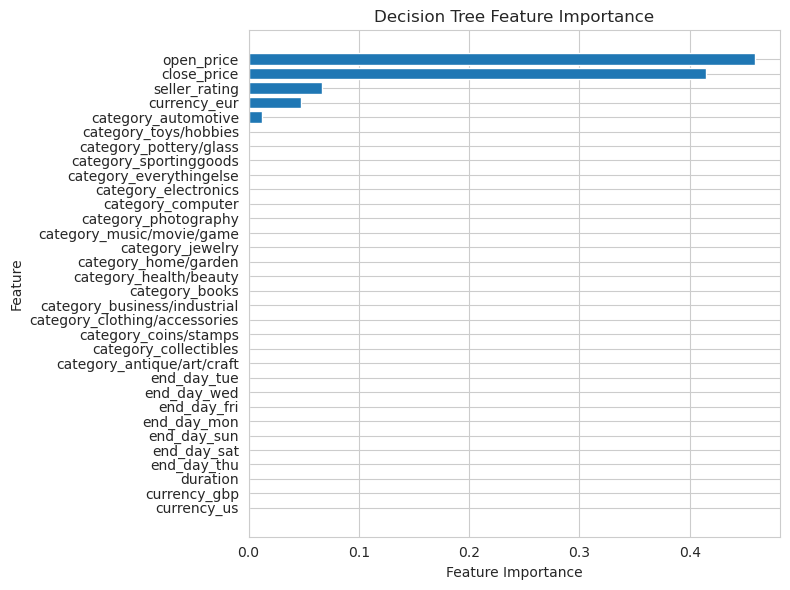

In [302]:
feature_importance_df_sorted = feature_importance_df.sort_values(by="importance", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(feature_importance_df_sorted["feature"], feature_importance_df_sorted["importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Decision Tree Feature Importance")
plt.tight_layout()
plt.show()

# Just include in the analysis that why dummy variable category_automotive is important. We need to inspect this????

# Redo the tree with only predictors usable in practice for new auctions. Plot the resulting tree as a tree diagram.

In [303]:
# Since there was not much difference between the hyperparameter tuned tree and the default tree. 
# Here, I will use the original tree with min_samples_leaf=50.


X = df[['open_price', 'close_price', 'seller_rating', 'currency_eur', 'category_automotive']]
y = df['competitive']

In [304]:
X

,open_price,close_price,seller_rating,currency_eur,category_automotive
0,0.01,0.01,3249,0,0
1,0.01,0.01,3115,0,1
2,0.01,0.01,3115,0,1
3,0.01,0.01,37727,0,0
4,0.01,0.06,3249,0,0
...,...,...,...,...,...
1621,359.95,359.95,2992,0,1
1622,300.00,610.00,21,0,1
1623,549.00,549.00,1400,0,1
1624,650.00,820.00,57,0,1


In [305]:
y

0       0
1       0
2       1
3       0
4       1
       ..
1621    0
1622    1
1623    0
1624    1
1625    0
Name: competitive, Length: 1626, dtype: int64

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [307]:
BestParamTree = DecisionTreeClassifier(random_state=1, min_samples_leaf=50)

In [308]:
BestParamTree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [309]:
y_predicted_new = BestParamTree.predict(X_test)
y_predicted_new

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,

In [310]:
accuracy_score(y_test, y_predicted_new)*100

# The accuracy score is same as earlier with all features, which is probably because the top 5 features contained almost all the information needed to make accurate predictions. And the rest of the features had almost zero importance.

80.95238095238095

In [311]:
classificationSummary(y_train, BestParamTree.predict(X_train))

Confusion Matrix (Accuracy 0.8113)

       Prediction
Actual   0   1
     0 302  73
     1 111 489


In [312]:
classificationSummary(y_test, BestParamTree.predict(X_test))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual   0   1
     0 193  59
     1  65 334


In [313]:
BestParamTree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [314]:
feature_names = list(X.columns)
feature_names

['open_price',
 'close_price',
 'seller_rating',
 'currency_eur',
 'category_automotive']

In [315]:
list_int = list(y.unique())
list_int

[np.int64(0), np.int64(1)]

In [316]:
class_names = list(map(str, list_int))
class_names

['0', '1']

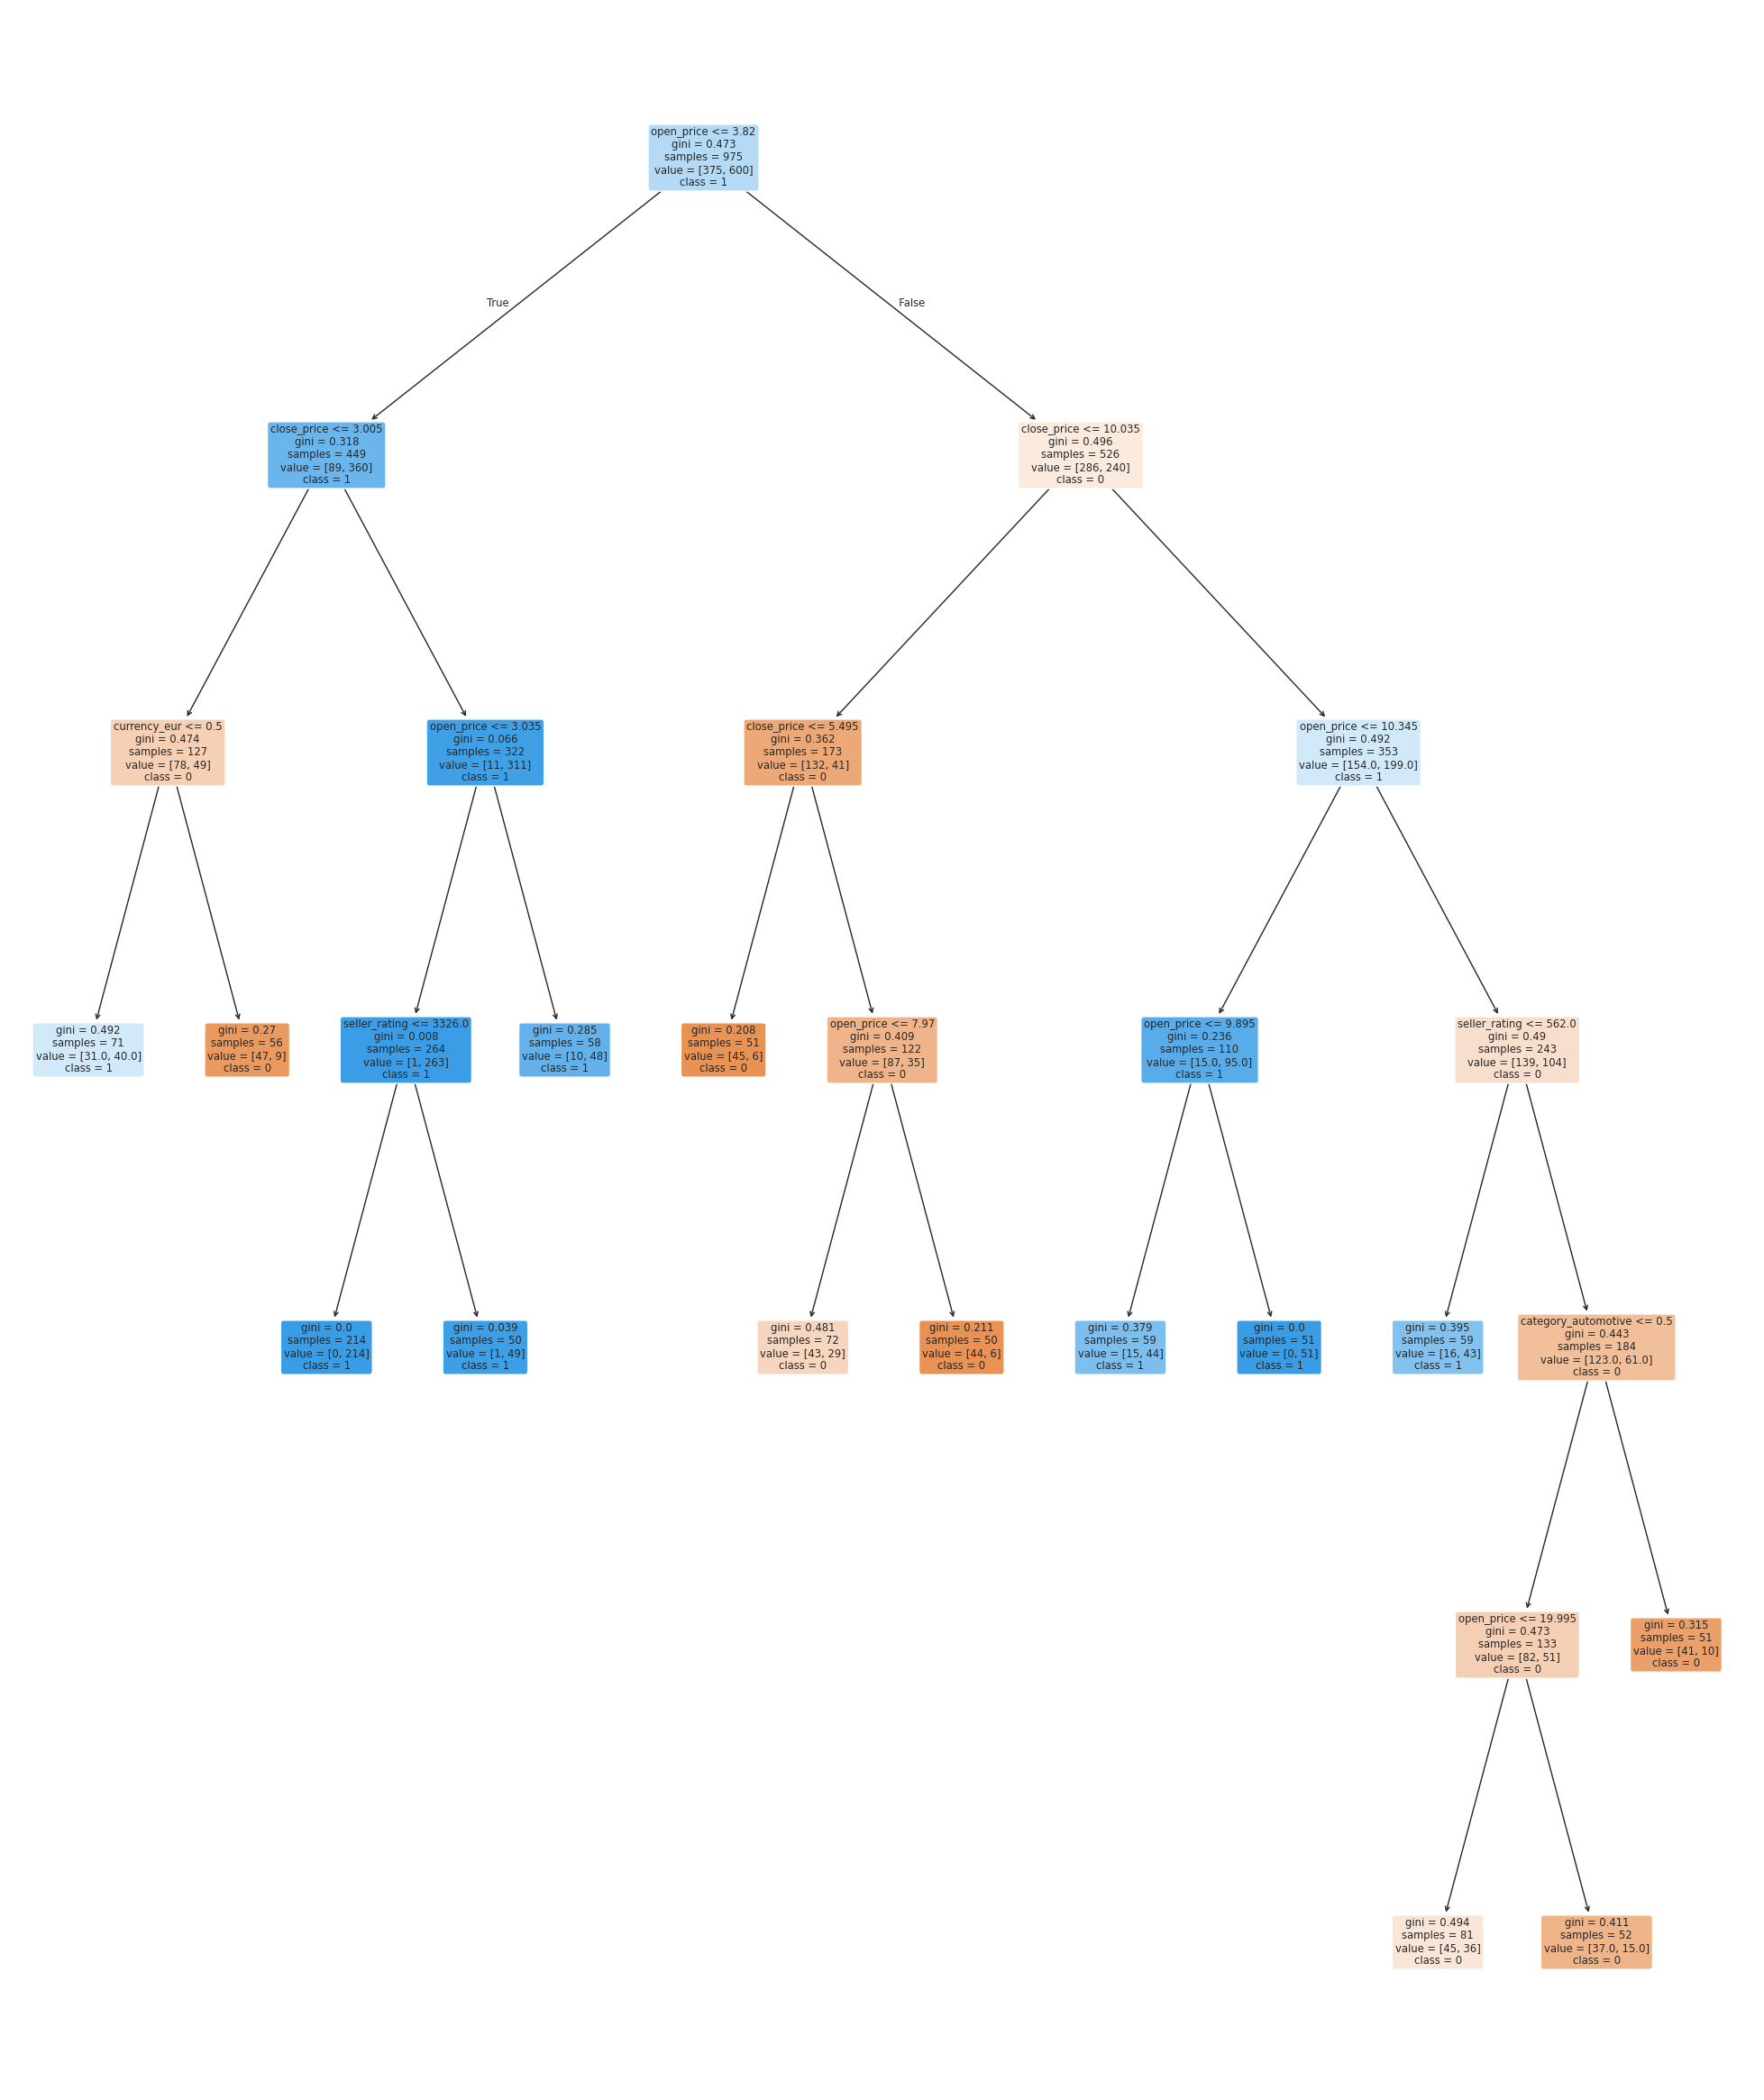

In [317]:
fig = plt.figure(figsize=(25,30))
tree.plot_tree(BestParamTree, feature_names=feature_names, class_names=class_names, rounded=True, filled=True)

plt.show()
fig.savefig("BestParamTree.png")

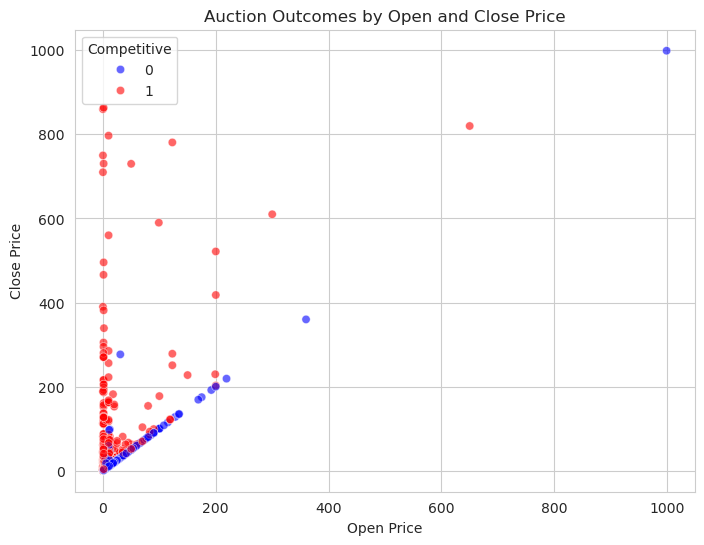

In [318]:
# for scatter plot we will choose open_price and close_price as two most important quatitative features.

# We use X_train and y_train for the scatter plot because the decision tree was trained on these data points. Plotting the training data allows us to see how the tree splits the auctions based on the two chosen features. Each point represents an auction from the training set, and its color shows whether it was competitive or non-competitive. This way, the plot clearly illustrates how the tree “learned” to separate the outcomes using the selected features.


plt.figure(figsize=(8,6))

sns.scatterplot(data=X_train, x="open_price", y="close_price", hue=y_train,  palette={0:'blue', 1:'red'}, alpha=0.6)

plt.xlabel("Open Price")
plt.ylabel("Close Price")
plt.title("Auction Outcomes by Open and Close Price")
plt.legend(title="Competitive")
plt.show()

plt.show()

# KNN 

In [319]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [320]:
df.head()

,seller_rating,duration,close_price,open_price,competitive,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
0,3249,5,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3115,7,0.01,0.01,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3115,7,0.01,0.01,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,37727,7,0.01,0.01,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3249,5,0.06,0.01,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [321]:
df.shape

(1626, 33)

In [322]:
X = df.drop(columns=['competitive'])
y = df['competitive']

In [323]:
test_size = 0.4
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [324]:
X_train

,seller_rating,duration,close_price,open_price,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
171,5701,10,1.23,1.23,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
649,1266,7,5.14,4.89,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
260,70,7,2.45,2.45,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1263,67,5,26.00,9.99,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1447,2218,3,30.00,30.00,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,814,3,11.99,11.99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1294,442,10,381.53,1.23,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
860,1130,10,17.22,4.92,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1459,29,5,43.00,24.99,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [325]:
y_train

171     0
649     1
260     0
1263    1
1447    0
       ..
1130    0
1294    1
860     0
1459    1
1126    1
Name: competitive, Length: 975, dtype: int64

In [326]:
X_test

,seller_rating,duration,close_price,open_price,currency_eur,currency_gbp,currency_us,end_day_fri,end_day_mon,end_day_sat,end_day_sun,end_day_thu,end_day_tue,end_day_wed,category_antique/art/craft,category_automotive,category_books,category_business/industrial,category_clothing/accessories,category_coins/stamps,category_collectibles,category_computer,category_electronics,category_everythingelse,category_health/beauty,category_home/garden,category_jewelry,category_music/movie/game,category_photography,category_pottery/glass,category_sportinggoods,category_toys/hobbies
816,34,7,173.12,0.89,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1167,2220,3,169.87,0.99,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1434,2358,5,86.00,9.99,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1220,27132,5,216.00,0.99,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
303,54,5,5.53,1.23,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,3896,1,230.00,1.00,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1100,164,7,30.62,6.03,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1546,1364,5,65.95,65.95,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
167,3057,10,1.23,1.23,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [327]:
y_test

816     1
1167    1
1434    1
1220    1
303     1
       ..
1245    1
1100    0
1546    0
167     0
12      1
Name: competitive, Length: 651, dtype: int64

In [328]:
num_folds = 10

model = KNeighborsClassifier()

# This is classification and not regression.
scoring = 'accuracy'

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
print(kfold)

KFold(n_splits=10, random_state=42, shuffle=True)


In [329]:
#  Now, I will show how the data is split into training and validation sets for each fold.

# for train_index, validate_index in kfold.split(X_train):
#     print("Training:", train_index, "Validation:", validate_index)

In [330]:
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(cv_results)

[0.70408163 0.7755102  0.68367347 0.78571429 0.74489796 0.79381443
 0.71134021 0.65979381 0.71134021 0.71134021]


In [331]:
mean_score = cv_results.mean()   
std_score = cv_results.std()     

msg = f"KNN Accuracy: {mean_score:.4f} (mean) {std_score:.4f} (std)"
print(msg)

KNN Accuracy: 0.7282 (mean) 0.0427 (std)


Hyperparameter tuning - Kfold to find best number of neighbors

In [332]:
# Now we will scale the training data

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

print(X_train_scaled)

[[ 3.69957832e-01  1.70829623e+00 -4.08605563e-01 ... -9.65234178e-02
  -2.78115203e-01 -3.39942114e-01]
 [-3.73194162e-01  2.82278401e-01 -3.70017504e-01 ... -9.65234178e-02
   3.59563227e+00 -3.39942114e-01]
 [-5.73602231e-01  2.82278401e-01 -3.96565299e-01 ... -9.65234178e-02
  -2.78115203e-01 -3.39942114e-01]
 ...
 [-3.95983040e-01  1.70829623e+00 -2.50799153e-01 ... -9.65234178e-02
  -2.78115203e-01 -3.39942114e-01]
 [-5.80472408e-01 -6.68400153e-01  3.62544038e-03 ... -9.65234178e-02
  -2.78115203e-01 -3.39942114e-01]
 [ 3.96104924e+00 -6.68400153e-01  9.88065053e-01 ... -9.65234178e-02
   3.59563227e+00 -3.39942114e-01]]


In [333]:
k_values = np.arange(1,22)

param_grid = dict(n_neighbors=k_values)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(X_train_scaled, y_train)

In [334]:
print(f"Best Score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")

Best Score: 0.6738 using {'n_neighbors': np.int64(3)}


Fitting KNN

In [335]:
model = KNeighborsClassifier(n_neighbors=grid_result.best_params_['n_neighbors'])
model.fit(X_train_scaled, y_train)

,n_neighbors,np.int64(3)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [336]:
X_test_scaled = scaler.transform(X_test)

In [337]:
y_pred = model.predict(X_test_scaled)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,

In [338]:
print(y_test)

816     1
1167    1
1434    1
1220    1
303     1
       ..
1245    1
1100    0
1546    0
167     0
12      1
Name: competitive, Length: 651, dtype: int64


In [339]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.4f}")

Accuracy on Test Set: 0.6897


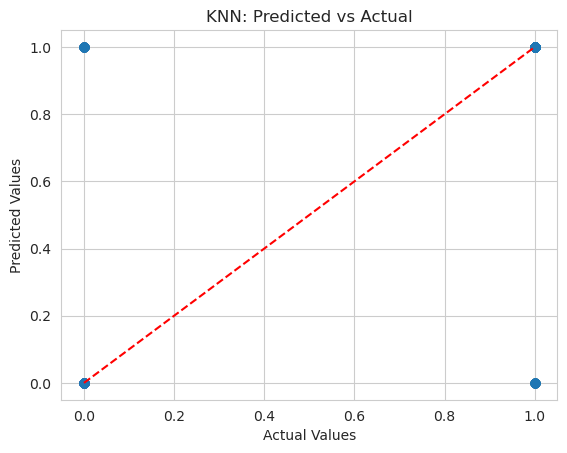

In [340]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("KNN: Predicted vs Actual")
plt.show()

In [341]:
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': np.int64(3),
 'p': 2,
 'weights': 'uniform'}

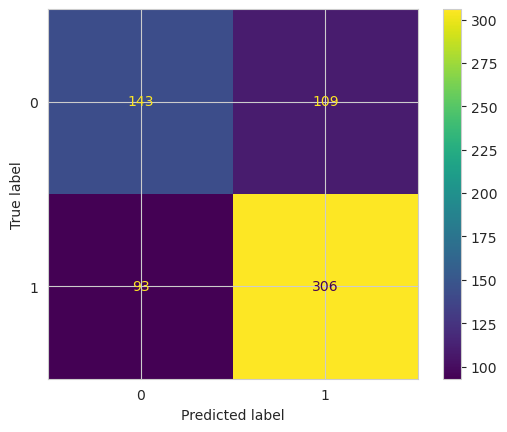

In [342]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [343]:
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       252
           1       0.74      0.77      0.75       399

    accuracy                           0.69       651
   macro avg       0.67      0.67      0.67       651
weighted avg       0.69      0.69      0.69       651



In [344]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6897
